## Laboratorio 4 clasificacion Multiclase

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Mis librerias

In [ ]:
## Valda Plaza Camila Monserrat
## Ing. Sistemas

# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize

# modulo para cargar archivos en formato MATLAB
# from scipy.io import loadmat

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

# Import pandas for data manipulation
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

Este dataset refleja trayectorias académicas anonimas de estudiantes, incluyendo su perfil, rendimiento y contexto socioeconómico, con el objetivo de predecir si un estudiante se graduará, abandonará o seguirá inscrito.


In [ ]:
# Número de etiquetas
num_labels = 3 # Asumiendo que todavía quieres clasificar en 3 categorías principales

# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/Laboratorio 4 - versión mejorada/academic_data.csv')

Esta celda revisa si el dataset tiene valores nulos en alguna columna y, en caso de encontrarlos, los reemplaza automáticamente para no perder información. Los valores numéricos se sustituyen por la media de su columna, mientras que los categóricos se reemplazan por el valor más frecuente (modo). Al final, imprime un mensaje indicando si hubo nulos y muestra la cantidad de valores nulos por columna, dejando el dataset listo para el análisis y entrenamiento del modelo.


In [ ]:
# Verificar si existen valores nulos en el dataset
print("\nCantidad de valores nulos por columna:")
print(data.isnull().sum())

# Si existen valores nulos, aplicar reemplazo
if data.isnull().sum().any():
    print("\n Se encontraron valores nulos. Reemplazando...")

    for col in data.columns:
        if data[col].dtype in ['int64', 'float64']:
            # Reemplazar valores nulos numéricos con la media
            data[col].fillna(data[col].mean(), inplace=True)
        else:
            # Reemplazar valores nulos categóricos con el valor más frecuente (modo)
            data[col].fillna(data[col].mode()[0], inplace=True)

    print("\n Valores nulos reemplazados.")
    print(data.isnull().sum())
else:
    print("\n No se encontraron valores nulos.")


Cantidad de valores nulos por columna:
Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder      

In [ ]:
# Separar características (X) y objetivo (y)
X = data.iloc[:, 1:]
y = data.iloc[:, 0].copy()  # Copia para evitar SettingWithCopyWarning

In [ ]:
# Basado en la distribución, mapearemos las clases minoritarias (3,4,5,6) a una sola clase (2).
# La clase original 1 se mapeará a 0, la clase original 2 se mapeará a 1.
y_mapped = y.copy()
y_mapped[y == 1] = 0
y_mapped[y == 2] = 1
y_mapped[(y >= 3) & (y <= 6)] = 2
y = y_mapped

# Imprimir distribución de clases después del mapeo
print("Ejemplos por clase después de mapear:")
print(y.value_counts())

Ejemplos por clase después de mapear:
Marital status
0    70189
1     5296
2     1033
Name: count, dtype: int64


In [ ]:
# Dividir datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
# Usamos el conjunto completo para el split inicial before resampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nForma de los datos de entrenamiento antes del remuestreo: {X_train.shape}")
print(f"Forma de los datos de prueba: {X_test.shape}")


Forma de los datos de entrenamiento antes del remuestreo: (61214, 36)
Forma de los datos de prueba: (15304, 36)


De aqui para abajo hacemos el balanceo del dataset

In [ ]:
# Verificar el balance del dataset en el conjunto de entrenamiento antes del remuestreo
print("\nDistribución de etiquetas en los datos de entrenamiento antes del remuestreo:")
print(y_train.value_counts(normalize=True))

# Verificar el balance del dataset en el conjunto de prueba
print("\nDistribución de etiquetas en los datos de prueba:")
print(y_test.value_counts(normalize=True))


Distribución de etiquetas en los datos de entrenamiento antes del remuestreo:
Marital status
0    0.917290
1    0.069216
2    0.013494
Name: proportion, dtype: float64

Distribución de etiquetas en los datos de prueba:
Marital status
0    0.917277
1    0.069198
2    0.013526
Name: proportion, dtype: float64


Esta celda aplica oversampling al conjunto de entrenamiento para balancear las clases minoritarias y evitar que el modelo se sesgue hacia la clase mayoritaria. Usando RandomOverSampler, se duplican ejemplos de las clases con menos datos hasta igualar la cantidad de la clase más grande. Al final, se imprime la nueva forma del conjunto de entrenamiento y la distribución de etiquetas para confirmar que todas las clases tienen ahora proporciones similares.


In [ ]:
# Aplicar oversampling solo al conjunto de entrenamiento to avoid data loss
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print(f"\nForma de los datos de entrenamiento después de oversampling: {X_train_resampled.shape}")
print("\nDistribución de etiquetas en los datos de entrenamiento después de oversampling:")
print(y_train_resampled.value_counts(normalize=True))


Forma de los datos de entrenamiento después de oversampling: (168453, 36)

Distribución de etiquetas en los datos de entrenamiento después de oversampling:
Marital status
0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64


Esta celda calcula y muestra el número total de ejemplos en el conjunto de entrenamiento después de aplicar el oversampling y determina el tamaño de la capa de entrada basado en la cantidad de características del dataset. Finalmente, actualiza las variables de entrenamiento para que el modelo utilice los datos remuestreados y balanceados durante el entrenamiento.


In [ ]:
m = y_train_resampled.size
input_layer_size = X_train_resampled.shape[1] # Actualizar input_layer_size basado en el número de características

print(f"\nNúmero de ejemplos de entrenamiento después del remuestreo: {m}")
print(f"Tamaño de la capa de entrada: {input_layer_size}")

# Ahora usaremos los datos remuestreados para el entrenamiento
X_train = X_train_resampled
y_train = y_train_resampled


Número de ejemplos de entrenamiento después del remuestreo: 168453
Tamaño de la capa de entrada: 36


In [ ]:
print(m)

168453


In [ ]:
print(X.iloc[0,:])
print(y)

Application mode                                     1.000000
Application order                                    1.000000
Course                                            9238.000000
Daytime/evening attendance                           1.000000
Previous qualification                               1.000000
Previous qualification (grade)                     126.000000
Nacionality                                          1.000000
Mother's qualification                               1.000000
Father's qualification                              19.000000
Mother's occupation                                  5.000000
Father's occupation                                  5.000000
Admission grade                                    122.600000
Displaced                                            0.000000
Educational special needs                            0.000000
Debtor                                               0.000000
Tuition fees up to date                              1.000000
Gender  

Esta celda define la función featureNormalize, que se encarga de **normalizar las características** del dataset para que todas tengan media cero y desviación estándar uno. Esto facilita que el modelo de regresión logística converja más rápido y de manera más estable, evitando que variables con rangos muy distintos dominen el entrenamiento. La función devuelve el dataset normalizado junto con la media (mu) y desviación estándar (sigma) de cada característica, por si se necesitan para transformar nuevos datos más adelante.


In [ ]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [ ]:
# llama featureNormalize con los datos cargados
# X_norm, mu, sigma = featureNormalize(X)
X_train_norm, mu, sigma = featureNormalize(X_train)
X_test_norm = (X_test - mu) / sigma

In [ ]:
print(X_train_norm.iloc[0,:])
print(y)

Application mode                                 -1.749223
Application order                                 0.823801
Course                                            0.290631
Daytime/evening attendance                        0.656561
Previous qualification                           -0.518103
Previous qualification (grade)                    0.315242
Nacionality                                      -0.064179
Mother's qualification                           -1.895036
Father's qualification                           -0.736774
Mother's occupation                              -0.360018
Father's occupation                              -0.063146
Admission grade                                   0.084165
Displaced                                         1.539679
Educational special needs                        -0.043215
Debtor                                           -0.339583
Tuition fees up to date                           0.482209
Gender                                            1.4070

Esta celda prepara la matriz de características para el entrenamiento del modelo y asigna X_train_norm a X. Aquí se deja lista la matriz de entrada, y se menciona que se puede agregar una columna de unos para el término de intercepción, aunque en este caso no se activa.

In [ ]:
# Configurar la matriz adecuadamente, y agregar una columna de unos que corresponde al termino de intercepción.
m, n = X.shape
# Agraga el termino de intercepción a A
# X = np.concatenate([np.ones((m, 1)), X_norm], axis=1)
X = X_train_norm
# X = np.concatenate([np.ones((m, 1)), X], axis=1)

Se define la función sigmoid, que calcula la función sigmoide sobre un valor o vector z. Esta función transforma cualquier valor real a un rango entre 0 y 1, lo cual es fundamental para la regresión logística. Además, se usa np.clip para evitar errores por números muy grandes o pequeños.

In [ ]:
#def sigmoid(z):
     #"""
     #Calcula la sigmoide de z.
     #"""
     #return 1.0 / (1.0 + np.exp(-z))
def sigmoid(z):
    """
    Calcula la sigmoide de z
    """
    z = np.clip(z, -500, 500)  # evita overflow
    return 1.0 / (1.0 + np.exp(-z))

La función calcularCosto calcula el costo de la regresión logística para un conjunto de parámetros theta. Esto mide qué tan bien el modelo se ajusta a los datos, usando la función sigmoide para estimar probabilidades y la función de costo logarítmica.

In [ ]:
def calcularCosto(theta, X, y):
    # Inicializar algunos valores utiles
    m = y.size  # numero de ejemplos de entrenamiento

    J = 0
    h = sigmoid(X.dot(theta.T))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))

    return J

Se define descensoGradiente, que actualiza iterativamente los parámetros theta para minimizar el costo calculado por la función anterior. Cada iteración ajusta theta en la dirección que reduce el error y guarda el costo en J_history para ver la evolución del entrenamiento.

In [ ]:
def descensoGradiente(theta, X, y, alpha, num_iters):
    # Inicializa algunos valores
    m = y.shape[0] # numero de ejemplos de entrenamiento

    # realiza una copia de theta, el cual será acutalizada por el descenso por el gradiente
    theta = theta.copy()
    J_history = []

    for i in range(num_iters):
        h = sigmoid(X.dot(theta.T))
        theta = theta - (alpha / m) * (h - y).dot(X)

        J_history.append(calcularCosto(theta, X, y))
    return theta, J_history

La función lrCostFunction calcula el costo y el gradiente para la regresión logística regularizada, considerando un parámetro lambda_ que evita sobreajuste. Devuelve tanto el valor de la función de costo como el gradiente, que se usa para actualizar theta durante el entrenamiento.

In [ ]:
def lrCostFunction(theta, X, y, lambda_):
    """
    Calcula el costo de usar theta como parámetro para la regresión logística regularizada y
    el gradiente del costo w.r.t. a los parámetros.

    Parametros
    ----------
    theta : array_like
        Parametro theta de la regresion logistica. Vector de la forma(shape) (n, ). n es el numero de caracteristicas
        incluida la intercepcion

    X : array_like
        Dataset con la forma(shape) (m x n). m es el numero de ejemplos, y n es el numero de
        caracteristicas (incluida la intercepcion).

    y : array_like
        El conjunto de etiquetas. Un vector con la forma (shape) (m, ). m es el numero de ejemplos

    lambda_ : float
        Parametro de regularización.

    Devuelve
    -------
    J : float
        El valor calculado para la funcion de costo regularizada.

    grad : array_like
        Un vector de la forma (shape) (n, ) que es el gradiente de la
        función de costo con respecto a theta, en los valores actuales de theta..
    """
#     alpha = 0.003
#     theta = theta.copy()
    # Inicializa algunos valores utiles
    m = y.size

    # convierte las etiquetas a valores enteros si son boleanos
    if y.dtype == bool:
        y = y.astype(int)

    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(X.dot(theta.T))

    temp = theta
    temp[0] = 0

#     J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    grad = (1 / m) * (h - y).dot(X)
#     theta = theta - (alpha / m) * (h - y).dot(X)
    grad = grad + (lambda_ / m) * temp

    return J, grad
#    return J, theta

OneVsAll entrena un clasificador de regresión logística para cada clase (estrategia “uno contra todos”). Para cada clase, ajusta theta usando descensoGradiente y grafica la convergencia del costo. Devuelve todos los parámetros entrenados y la historia de costos para análisis posterior.

In [ ]:
def OneVsAll(X, y, num_labels, lambda_):
  alpha = 0.01
  num_iters = 50000

  m, n = X.shape
  all_theta = np.zeros((num_labels, n + 1))
  all_J_history = []

  X = np.concatenate([np.ones((m, 1)), X], axis=1)

  pyplot.figure()

  for c in np.arange(num_labels):
      initial_theta = np.zeros(n + 1)

      y_actual = np.where(y == c, 1, 0)

      theta, J_history = descensoGradiente(initial_theta, X, y_actual, alpha, num_iters)

      all_theta[c] = theta
      all_J_history.append(J_history)
      pyplot.plot(np.arange(len(J_history)), J_history, lw=2, label=f'Class {c}')
      pyplot.xlabel('Numero de iteraciones')
      pyplot.ylabel('Costo J')
      pyplot.title('Convergencia del Costo por Clase')

  pyplot.legend()
  pyplot.show()

  return all_theta, all_J_history

OneVsAllOM es otra versión de entrenamiento “uno contra todos”, pero usa optimize.minimize de SciPy para encontrar los mejores parámetros theta de forma automática. Entrena un clasificador por cada clase y devuelve la matriz con todos los parámetros entrenados.

In [ ]:
def OneVsAllOM(X, y, num_labels, lambda_):
    """
    Trains num_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.

    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). m is the number of
        data points, and n is the number of features. Note that we
        do not assume that the intercept term (or bias) is in X, however
        we provide the code below to add the bias term to X.

    y : array_like
        The data labels. A vector of shape (m, ).

    num_labels : int
        Number of possible labels.

    lambda_ : float
        The logistic regularization parameter.

    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        (ie. `numlabels`) and n is number of features without the bias.
    """
    # algunas variables utiles
    m, n = X.shape

    all_theta = np.zeros((num_labels, n + 1))

    # Agrega unos a la matriz X
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 10}
        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                (X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                options=options)

        all_theta[c] = res.x


    return all_theta

In [ ]:
lambda_ = 0.1
all_theta = OneVsAllOM(X_train, y_train, num_labels, lambda_)

/tmp/ipython-input-3271430271.py:49: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))


In [ ]:
print(all_theta)

[[ 1.29345066e-04 -6.58423075e-02  2.38507295e-03 -9.28278801e-05
   1.52102124e-03 -7.94715800e-03  2.02346855e-02 -4.32634353e-04
  -3.28389565e-02 -1.91338698e-02 -8.27129822e-03 -3.62645809e-03
   1.79190544e-02  1.88542635e-03  1.33482997e-05 -1.62477768e-04
   5.97905186e-04  2.09766712e-05  4.78987605e-04 -5.70049553e-02
   1.41247704e-06 -6.62325801e-04  1.38969821e-05  6.10594150e-04
   4.32905587e-03  8.42944218e-03 -1.41994084e-04 -4.82221609e-04
   3.12251699e-04  2.17740798e-03  4.56686031e-03  9.10111371e-03
  -2.44524569e-04  2.88542604e-03 -3.18696640e-04  1.28880149e-03
  -2.21537467e-04]
 [-1.00881041e-04  3.14443114e-02 -1.18928153e-03 -7.37918008e-05
  -9.96232348e-04 -7.51445702e-04 -1.47097909e-02 -3.95585321e-04
   1.94893643e-02  1.38006689e-02 -3.82408943e-03 -4.89272742e-03
  -4.59228407e-03 -6.83784536e-04 -7.83070169e-06  3.07366957e-05
  -3.02309733e-04  6.76720661e-04 -5.36736882e-04  2.16278609e-02
  -1.30447494e-06  5.21982020e-04 -9.49065271e-04  3.0743

<a id="section3"></a>
#### 1.4.1 Prediccion One-vs-all



predictOneVsAll toma los parámetros entrenados all_theta y un conjunto de datos X y devuelve un vector con las predicciones de clase para cada ejemplo. Calcula la probabilidad con la sigmoide y asigna la clase con mayor probabilidad a cada ejemplo.

In [ ]:
def predictOneVsAll(all_theta, X):
    """
    Devuelve un vector de predicciones para cada ejemplo en la matriz X.
    Tenga en cuenta que X contiene los ejemplos en filas.
    all_theta es una matriz donde la i-ésima fila es un vector theta de regresión logística entrenada para la i-ésima clase.
    Debe establecer p en un vector de valores de 0..K-1 (por ejemplo, p = [0, 2, 0, 1]
    predice clases 0, 2, 0, 1 para 4 ejemplos).

    Parametros
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features without the bias.

    X : array_like
        Data points to predict their labels. This is a matrix of shape
        (m x n) where m is number of data points to predict, and n is number
        of features without the bias term. Note we add the bias term for X in
        this function.

    Devuelve
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).
    """

    m = X.shape[0];
    num_labels = all_theta.shape[0]

    p = np.zeros(m)

    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

    return p

Se llama a la función OneVsAll con los datos normalizados y el parámetro de regularización lambda_. Luego se grafica la evolución del costo para cada clase durante el entrenamiento, mostrando cómo convergió cada clasificador. Finalmente, se imprimen los parámetros theta resultantes del entrenamiento.

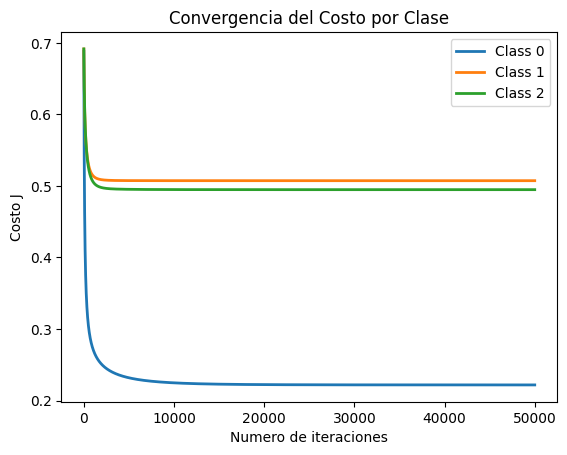

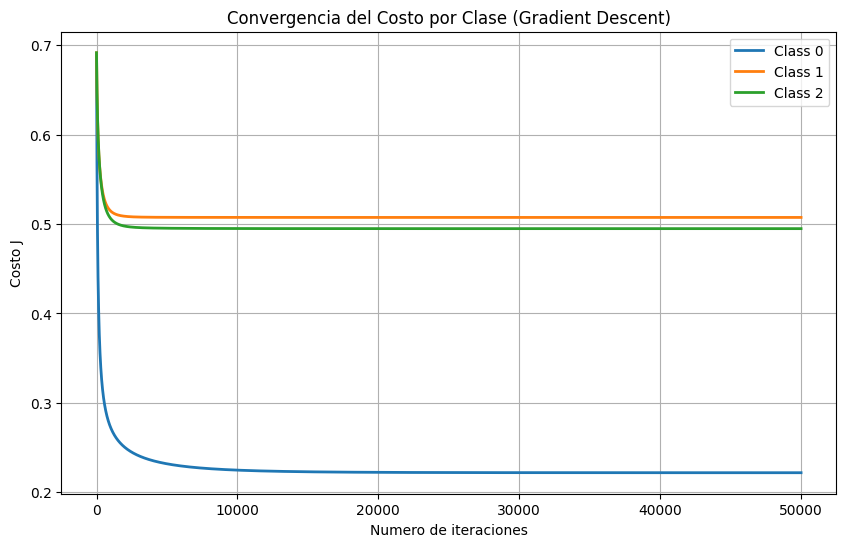

All Theta (from Gradient Descent):
[[-1.97467177e+00 -3.77358890e-01 -1.78623381e-02  3.84523664e-02
   2.77071644e-01 -7.02975551e-03 -1.79314893e-01 -1.41516154e-01
  -1.93421591e-01 -4.72845094e-02 -9.11099026e-02  7.38620588e-02
  -9.28578506e-02  5.22150293e-01  5.43233821e-02 -7.41656502e-04
   6.02804389e-02  2.60811966e-01 -1.26229463e-01 -2.91920146e+00
   1.38558401e-01  2.65168574e-01 -3.39435955e-01  3.26818807e-03
   1.32803805e-01 -7.22172514e-02  1.66383600e-02  3.98815062e-02
  -2.31579351e-01  7.70549148e-02  1.67071312e-01 -7.79695367e-02
  -1.23036090e-01  3.74515071e-01 -1.37161730e-01  1.67125635e-01
   2.91937042e-02]
 [-1.00067178e+00  4.85212499e-01 -1.77710576e-01  8.56131252e-02
  -1.95885971e-01 -1.08225491e-01  8.81911824e-03 -7.39561333e-02
   2.08151529e-01  1.55781302e-01 -9.01166548e-02 -8.94657162e-02
   8.82509698e-02 -1.60166131e-01  2.61776724e-05  4.15784093e-02
  -8.89223446e-03  2.91501923e-01 -2.81080639e-01  3.15437505e-01
   7.92676503e-02  8.7

In [ ]:
lambda_ = 0.001
all_theta, all_J_history = OneVsAll(X_train_norm, y_train, num_labels, lambda_)

pyplot.figure(figsize=(10, 6))
for c in range(num_labels):
    pyplot.plot(np.arange(len(all_J_history[c])), all_J_history[c], lw=2, label=f'Class {c}')

pyplot.xlabel('Numero de iteraciones')
pyplot.ylabel('Costo J')
pyplot.title('Convergencia del Costo por Clase (Gradient Descent)')
pyplot.legend()
pyplot.grid(True)
pyplot.show()

print("All Theta (from Gradient Descent):")
print(all_theta)

Aquí se calcula la precisión del modelo en todo el conjunto de prueba. Se muestra un porcentaje que indica qué tan bien generaliza el modelo a datos nuevos. Además, se sugiere que se podría graficar la convergencia del costo si se tuviera el historial de entrenamiento.


In [ ]:
# Calcular la precisión en el conjunto de prueba
pred_test = predictOneVsAll(all_theta, X_test_norm)
print('Precision del conjunto de prueba: {:.2f}%'.format(np.mean(pred_test == y_test) * 100))

# # Si se utilizó la función OneVsAll que devuelve J_history, se puede graficar el costo
if 'J_history' in locals():
    pyplot.figure()
    pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
    pyplot.xlabel('Numero de iteraciones')
    pyplot.ylabel('Costo J')
    pyplot.title('Convergencia del Costo')
    pyplot.show()

# # También se podría graficar la precisión si se calculó en cada iteración
# # Esto requeriría modificar la función de entrenamiento para devolver el historial de precisión

Precision del conjunto de prueba: 86.61%


En esta celda se calcula la precisión del modelo en el conjunto de entrenamiento y se hacen predicciones sobre un subconjunto de los datos de prueba. Se muestran las predicciones y las etiquetas reales para comparar el desempeño del modelo en datos que no fueron usados para entrenar.

In [ ]:
# Ahora usamos los datos remuestreados y normalizados para calcular la precisión del conjunto de entrenamiento
print(X_train_norm.shape)
pred = predictOneVsAll(all_theta, X_train_norm)
print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(pred == y_train) * 100))

# Realizar predicciones en un subconjunto de los datos de prueba normalizados
XPrueba = X_test_norm.iloc[100:145, :].copy()
print(XPrueba.shape)

# La función predictOneVsAll ya agrega la columna de unos, por lo que no es necesario hacerlo aquí
p = predictOneVsAll(all_theta, XPrueba)
print("Predicciones para el subconjunto de prueba:")
print(p)

# Mostrar las etiquetas reales para ese subconjunto de prueba
print("\nEtiquetas reales para el subconjunto de prueba:")
print(y_test.iloc[100:145])

(168453, 36)
Precision del conjuto de entrenamiento: 70.74%
(45, 36)
Predicciones para el subconjunto de prueba:
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0
 2 0 0 0 0 0 0 0]

Etiquetas reales para el subconjunto de prueba:
51337    0
29996    0
60691    0
32773    0
42034    0
48412    0
184      0
6407     0
16167    0
21838    0
28544    0
40228    0
19210    0
20550    0
54132    0
49388    0
18788    0
25766    1
63410    0
27217    0
62992    0
35815    0
63528    0
31388    0
4900     0
51497    1
39751    0
63499    0
24918    0
72447    0
64149    0
33588    0
50513    0
12184    0
17848    1
17273    0
2111     0
7285     1
14109    0
49993    0
27383    0
3871     0
11913    0
33327    0
3841     0
Name: Marital status, dtype: int64
